In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib as mpl
from scipy.interpolate import griddata 
import warnings
import os
import datetime as dt
import numpy as np
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
warnings.filterwarnings('ignore')
from myTools import myInfo
from myTrend import myfitting2d_sttcs,myRegress3d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib as mpl
# mpl.use('agg')

### ======================================================================
pthMO='J:/tmp_proc/Models/'
pthrn='J:/tmp_proc/Obs/'

varnm='temp'
myindx='SAM'

t_rng=['1993-01', '2017-12']
lat_rng=[-80,-30]; lon_rng=[0,360]

wpth='C:/Users/shjo/OneDrive/mySO/Regression_H/tmp/'+myindx+'/'
mySig_npth='C:/Users/shjo/OneDrive/mySO/mySignals/my'+myindx+'.pkl'

### Preparation ============================================================
wpth=wpth+'WCssn_'+varnm+'500m_'+str(t_rng[0][:4])+'_'+str(t_rng[-1][:4])+'_'+\
    str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+'_'+\
        'E'+str(lon_rng[-1])+'E/'
wpth=wpth.replace('-','')
try :
    os.mkdir(wpth)
except:
    pass
loc=sys._getframe().f_code.co_filename
myInfo(loc,wpth)

myRnly=[pthrn+i for i in os.listdir(pthrn) if i.endswith('.nc')]
myMDOB=[pthMO+i for i in os.listdir(pthMO) if i.endswith('.nc')]
myDATA=myMDOB+myRnly
if int(t_rng[0].split('-')[0])<1992:
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myECCO')]
myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myISA')]

### load Index ==================================================================
with open(mySig_npth, 'rb') as f:
    data = pickle.load(f)
myIdx=data.loc['1993-01':'2017-12']

myIdx=(myIdx-myIdx.mean())/myIdx.std()

print('!!! Index --> Normalized !!!')

# print(mySAM)

myIdx_Cld=myIdx[ (myIdx.index.month==3)|(myIdx.index.month==4)|(myIdx.index.month==5)|\
    (myIdx.index.month==6)|(myIdx.index.month==7)|(myIdx.index.month==8)].resample('1Y').mean().values.reshape(-1)
myIdx_Wrm=myIdx[ (myIdx.index.month==10)|(myIdx.index.month==11)|(myIdx.index.month==12)|\
    (myIdx.index.month==1)|(myIdx.index.month==2)][2:]
myIdx_Wrm=np.array([myIdx_Wrm['SAM'][5*n:5*n+5].mean() for n in range(int(len(myIdx_Wrm)/5))])



### Read Data ==============================================================
for i in myDATA: 
    print('!!! Open: '+i+' !!!')
    tmp=xr.open_dataset(i)
    if len(tmp.coords)==4:
        mydata = tmp[varnm].loc[dict(lat=slice(lat_rng[0],lat_rng[-1])\
            ,time=slice(t_rng[0],t_rng[-1]),depth=slice(450,550))].mean(dim='depth')
  
    mydata=mydata.where(mydata<1000)
    mydata=mydata.where(mydata>-1000)
    
    mydata=mydata.fillna(0)
    
    lonR,latR=mydata.lon.values,mydata.lat.values
    lonR_m,latR_m=np.meshgrid(lonR,latR)
    time=mydata.time.values
    dta_nm=i.split('/')[-1][2:-3].split('_')[0]+' '+varnm+'500m regression ('+myindx+')\n'+\
        'QQQ'+str(lon_rng[0])+'~'+str(lon_rng[-1])+'E '+str(time[0])[:4]+' '+str(time[-1])[:4]
    dta_snm=i.split('/')[-1][2:-3].split('_')[0]+' '+varnm+'500m regression '+myindx+'_'+\
        str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+' '+str(lon_rng[0])+'E'+str(lon_rng[-1])+'E_'+\
            str(time[0])[:4]+' '+str(time[-1])[:4]
    
    dta_snm=dta_snm.replace(' ','_').replace('salt','salinity').replace('-','')
    dta_nm=dta_nm.replace('salt','salinity').replace('-','')
    
    # mydata.time.dt.month==
    Cld_ssn_=mydata.loc[ (mydata.time.dt.month==3)|(mydata.time.dt.month==4)|(mydata.time.dt.month==5)|\
        (mydata.time.dt.month==6)|(mydata.time.dt.month==7)|(mydata.time.dt.month==8)]
    # mydata.time.dt.month==
    Wrm_ssn_=mydata.loc[ (mydata.time.dt.month==10)|(mydata.time.dt.month==11)|(mydata.time.dt.month==12)|\
        (mydata.time.dt.month==1)|(mydata.time.dt.month==2)][2:]

    Wrm_ssn=Wrm_ssn_[5*0:5*0+5].mean(dim='time')
    for n in range(1,int(len(Wrm_ssn_)/5)):
        Wrm_ssn=xr.concat([Wrm_ssn_[5*n:5*n+5].mean(dim='time',keepdims=True),Wrm_ssn],dim='time')
    # myIdx_Cld=np.array([myIdx_Cld['SAM'][5*n:5*n+5].mean() for n in range(int(len(myIdx_Cld)/5))])

    # Wrm_ssn=Wrm_ssn_.groupby('time.year').mean()
    Cld_ssn=Cld_ssn_.groupby('time.year').mean()


    # Linear regressiong
    slope_Wrm,intercept_Wrm,r_value_Wrm,p_value_Wrm,std_err_Wrm,smask_Wrm=\
        myRegress3d_sttcs(myIdx_Wrm,Wrm_ssn,threshold=0.05)
    slope_Cld,intercept_Cld,r_value_Cld,p_value_Cld,std_err_Cld,smask_Cld=\
        myRegress3d_sttcs(myIdx_Cld,Cld_ssn,threshold=0.05)
    
    smask_Wrm[slope_Wrm==0]=np.nan
    smask_Cld[slope_Cld==0]=np.nan
    
    # Figure
    myN=16
    mylim=[-.2,.2]
    CMAP,mylevel=myClrbr('myblc2',mylim,myN)
    CMAP_salt,mylevel_salt=myClrbr('salt',mylim,myN)
    CMAP_temp,mylevel_temp=myClrbr('balance',mylim,myN)

    slope_Wrm[slope_Wrm<mylim[0]]=mylim[0]
    slope_Wrm[slope_Wrm>mylim[-1]]=mylim[-1]
    
    slope_Cld[slope_Cld<mylim[0]]=mylim[0]
    slope_Cld[slope_Cld>mylim[-1]]=mylim[-1]
    
    mySetting={
        'figsize': '',
        'mylabel': '',
        'Label_size':18,
        'title_loc':'right',
        'fontParams':'Arial',
        'wpth':wpth}
    lat_rng_,lon_rng_=[-60,-53],[200,250]

    F=figmaster(mySetting)
    F.myCrtpy_sph3_box(latR_m,lonR_m,slope_Wrm,smask_Wrm,CMAP,mylevel,dta_nm.replace('QQQ','Wrm '),\
        'Wrm_'+dta_snm,lat_rng_,lon_rng_)
    F.myCrtpy_sph3_box(latR_m,lonR_m,slope_Cld,smask_Cld,CMAP,mylevel,dta_nm.replace('QQQ','Cld '),\
        'Cld_'+dta_snm,lat_rng_,lon_rng_)


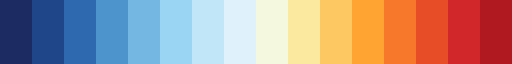

In [2]:
CMAP

In [9]:
mylevel

array([-0.2       , -0.17777778, -0.15555556, -0.13333333, -0.11111111,
       -0.08888889, -0.06666667, -0.04444444, -0.02222222,  0.        ,
        0.02222222,  0.04444444,  0.06666667,  0.08888889,  0.11111111,
        0.13333333,  0.15555556,  0.17777778,  0.2       ])

In [ ]:

def myCrtpy_sph3_box(LAT,LON,DATA,HATCH,CMAP,LEVELS,tnm,myName,lat_rng,lon_rng):
    
    a,b=[lon_rng[0], lon_rng[0]],[lat_rng[0],lat_rng[-1]]
    c,d=[lon_rng[-1], lon_rng[-1]],[lat_rng[0],lat_rng[-1]]
    e,f=[lon_rng[0], lon_rng[-1]],[lat_rng[0],lat_rng[0]]
    g,h=[lon_rng[0], lon_rng[-1]],[lat_rng[-1],lat_rng[-1]]
    
    Spheric=ccrs.SouthPolarStereo(central_longitude=0.0,globe=None)
    PC = ccrs.PlateCarree(central_longitude=0.0,globe=None)
    fig, ax = plt.subplots(1, 1, figsize=(12.5,11),
                    subplot_kw={'projection': Spheric})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=1,zorder=110)
    ax.add_feature(cartopy.feature.LAND,color=[.75,.75,.75],zorder=100)
    ax.set_title(tnm,loc='right',fontdict={'fontsize':32,'fontweight':'regular'})

    gl = ax.gridlines(crs=PC, draw_labels=True,y_inline=False,x_inline=False,
                    linewidth=.6, color='k', alpha=0.45, linestyle='-.')
    gl.rotate_labels=False
    gl.xlabels_top,gl.ylabels_right = True,True
    gl.xlabel_style = gl.ylabel_style = {"size" : 26}
    
    ax.plot(a,b,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    ax.plot(c,d,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    ax.plot(e,f,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    ax.plot(g,h,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    
    plt.contourf(LON,LAT,HATCH,levels=LEVELS,colors='none',hatches='.',transform=PC,zorder=2,extend='both')
    M=plt.contourf(LON,LAT,DATA,cmap=CMAP,levels=LEVELS,transform=PC,zorder=0,extend='both')
    # M=plt.contourf(LON,LAT,DATA,cmap=CMAP,transform=PC,zorder=0,extend='both')

    ax.set_extent([LON[0][0], LON[0][-1], LAT[0][0], LAT[-1][0]], crs=PC)
    
    ax.tick_params(axis='both', which='major', labelsize=28)

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=1., axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cb=plt.colorbar(M,extend='both',pad=0.08,cax=ax_cb)
    cb.set_label(label='', weight='regular',fontsize=28)
    cb.ax.tick_params(labelsize=19)
    plt.tight_layout()
    if 0:
        myName.replace(' ','_')
        # plt.savefig(w_path+'/ppt/'+save_name,
        #         facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(self.wpth+'/'+myName.replace(' ','_'))
    plt.show()

In [ ]:
lat_rng_,lon_rng_=[-60,-53],[200,250]
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf


myCrtpy_sph3_box(latR_m,lonR_m,slope_Wrm,smask_Wrm,CMAP,mylevel,dta_nm.replace('QQQ','Wrm '),\
    'Wrm_'+dta_snm,lat_rng_,lon_rng_)
myCrtpy_sph3_box(latR_m,lonR_m,slope_Cld,smask_Cld,CMAP,mylevel,dta_nm.replace('QQQ','Cld '),\
    'Cld_'+dta_snm,lat_rng_,lon_rng_)